# Variogram analysis and ordinary kriging for data in 1D

Interpolate a data set in 1D, using ordinary kriging. Starting from a data set in 1D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging.

**Note:** most of the tools illustrated below can also be used for data in 2D or 3D assuming omni-directional covariance / variogram models.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
#import geone.customcolors as ccol

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Preparation - build a data set in 1D
A data set in 1D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define the *reference* covariance model in 1D (class `covModel1D` from `geone.covModel`, see jupyter notebook `ex_grf_1d`).

In [2]:
cov_model_ref = gcm.CovModel1D(elem=[
    ('spherical', {'w':7., 'r':100}),   # elementary contribution
    ('exponential', {'w':2.5, 'r':50}), # elementary contribution
    ('nugget', {'w':0.5})               # elementary contribution
    ], name='ref model')

In [3]:
cov_model_ref

Covariance model 1D: (Name = ref model)
   3 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 7.0,  r = 100
   Elementary contribution 1: type : exponential
      parameters:  w = 2.5,  r = 50
   Elementary contribution 2: type : nugget
      parameters:  w = 0.5

Generate a gaussian random field in 1D (see function `grf1D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (1-dimensional array of length `n`),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx = 1000 # number of cells
dx = 0.5  # cell unit
ox = 0.0  # origin
# xmin, xmax = ox, ox + nx*dx # bounds of the simulation domain

# Reference simulation
np.random.seed(123)
ref = grf.grf1D(cov_model_ref, nx, dx, ox, nreal=1, printInfo=False) # 2d-array of shape 1 x nx

# Extract n points from the reference simulation
n = 25 # number of data points
ind = np.random.choice(nx, size=n, replace=False) # indexes of extracted grid cells
x = ox + (ind + 0.5)*dx # coordinates of data points (centers of the extracted grid cells)
#x = ox + (ind + np.random.random(n))*dx # coordinates of data points (within the extracted grid cells)
v = ref[0,ind] # value at data points

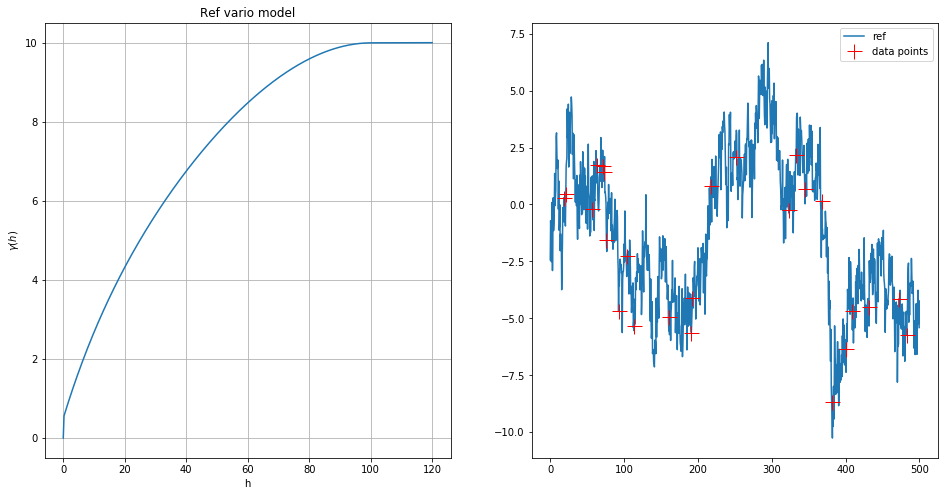

In [5]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')

plt.subplot(1,2,2)
plt.plot(ox + (np.arange(nx)+0.5)*dx, ref[0], label='ref')
plt.plot(x, v, 'r+', markersize=15, label='data points')
plt.legend()
plt.show()

## Start from a data set in 1D
- `n`: number of data points
- `x`: 1-dimensional array of length `n`: locations of data points
- `v`: 1-dimensional array of length `n`: values at data points

Visualise the data set and the histogram of values.

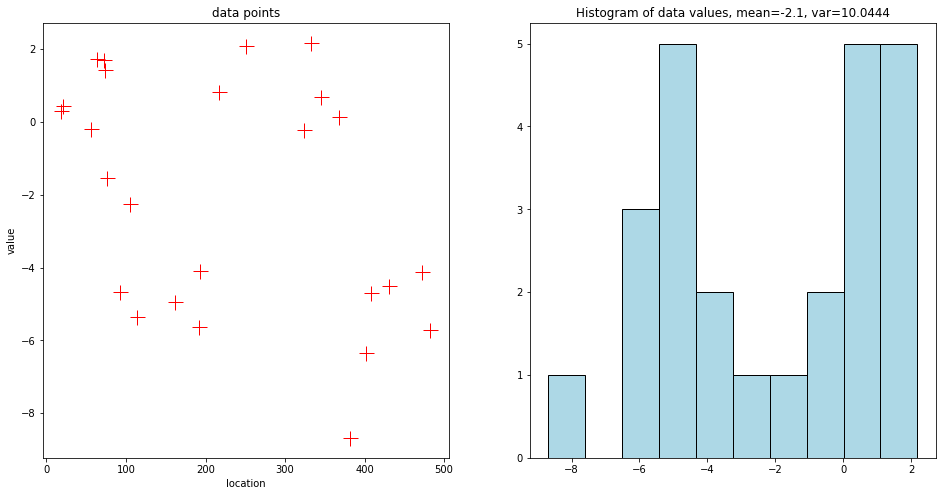

In [6]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(x, v, 'r+', markersize=15)
plt.xlabel('location')
plt.ylabel('value')
plt.title('data points')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram cloud
Compute the variogram cloud. The pair of the i-th and j-th data points gives the point $(h(i,j), g(i,j))$ in the variogram cloud, where
- $h(i,j) = \vert\vert x(i)-x(j)\vert\vert$ is the distance between $x(i)$ and $x(j)$ (lag)
- $g(i,j) = 1/2 \cdot (v(i)-v(j))^2)$ is the corresponding $\gamma$ value.

The function `variogramCloud1D` returns two 1-dimensional arrays `h` and `g` of same length `npair` containing the coordinates of the points in the variogram cloud. The maximal distance between two data points to be integrated in the variogram cloud can be specified by the keyword argument `hmax`. Note that a plot of the variogram cloud is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* variogram cloud.

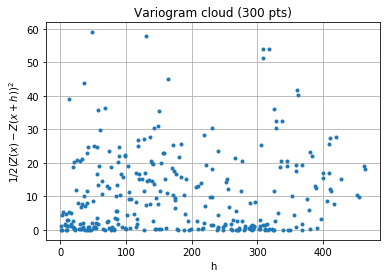

In [7]:
h, g, npair = gcm.variogramCloud1D(x, v)
plt.show()

### Experimental variogram
Compute the experimental variogram. It is obtained from the variogram cloud by computing the mean points of variogram cloud points within vertical bands (classes for the lags). A class for a lag is an interval along the $h$-axis. 

The function `variogramExp1D` returns three 1-dimensional arrays `hexp`, `gexp`, and `cexp` of same length (number of classes), where `hexp` and `gexp` contain the coordinates of the mean points of each class and `cexp` the number (counter) of points in each class.

The variogram cloud (if already computed) can be passed directly to the function `variogramExp1D` via the keyword argument `variogramCloud`: in this case, the arguments `x`, `v`, (and optional `hmax`) are not used. The classes can be defined in several ways: specifying the number of classes (`ncla`) / specifying the class centers (`cla_center`) / specifying the class length(s) (`cla_length`) (in particular overlapping classes are possible), see doc of the function). Note that a plot of the experimental variogram is made by default (keyword argument `make_plot=True`) with the counters displayed (keyword argument `show_count=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* experimental variogram.

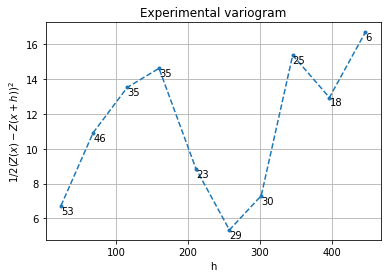

In [8]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v)
# hexp, gexp, cexp = gcm.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

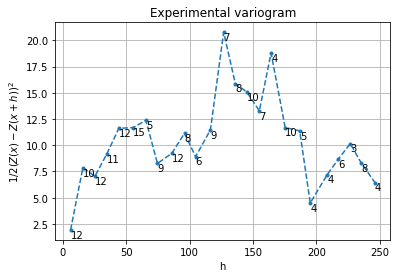

In [9]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v, hmax=250, ncla=25)
# hexp, gexp, cexp = gcm.variogramExp1D(x, v, cla_center=np.arange(5, 250, 10))
plt.show()

Note that the function `plot_variogramExp1D` allows to plot an experimental variogram (already computed): `gcm.plot_variogramExp1D(hexp, gexp, cexp)` gives the plot above.

### Model fitting
The function `covModel1D_fit` allows to fit a covariance / variogram model in 1D to given data.

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 1D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points (*i.e.* fit to the points of the variogram cloud). Hence, the fitting does not depend on the experimental variogram, *i.e.* on the choice of the classes for the lags.

The function `covModel1D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function fits an *omni-directional* model.

Covariance of the parameters could not be estimated


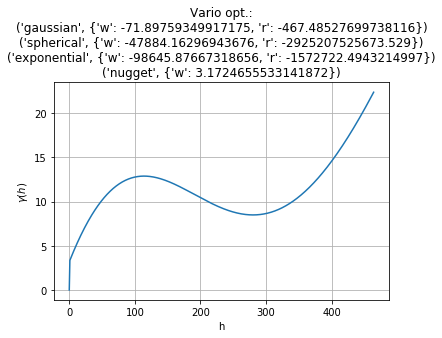

In [10]:
cov_model_to_optimize = gcm.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gcm.covModel1D_fit(x, v, cov_model_to_optimize)
plt.show()

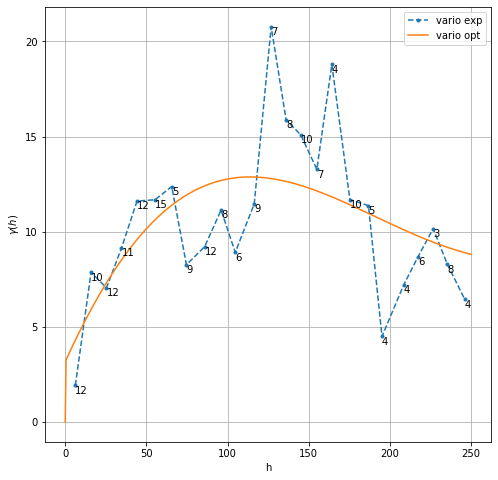

In [11]:
plt.figure(figsize=(8,8))
gcm.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
plt.legend()
plt.show()

#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `covModel1D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

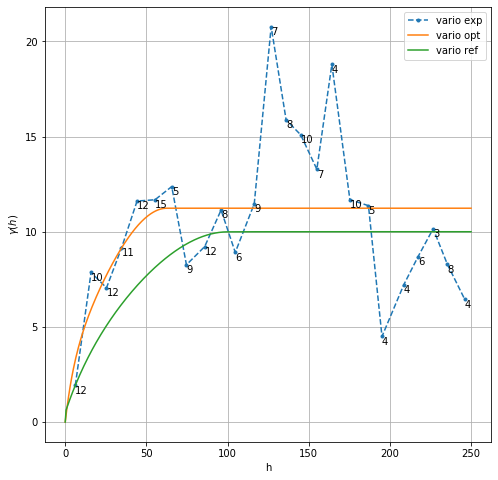

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 4.9737687754562765e-08,  r = 55.70155276592969
   Elementary contribution 1: type : spherical
      parameters:  w = 8.208193400255972,  r = 62.57536769327458
   Elementary contribution 2: type : exponential
      parameters:  w = 3.026727667451177,  r = 16.55360072595482
   Elementary contribution 3: type : nugget
      parameters:  w = 0.0010422011735221198

In [12]:
cov_model_to_optimize = gcm.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gcm.covModel1D_fit(x, v, cov_model_to_optimize,# hmax=300,
                                         bounds=([ 0,   0,  0,   0,  0,   0,  0], 
                                                 [20, 300, 20, 300, 20, 300, 20]),
                                         make_plot=False)
# bounds are given for:
#  index 0: parameter 'w' of gaussian contribution
#  index 1: parameter 'r' of gaussian contribution
#  index 2: parameter 'w' of spherical contribution
#  index 3: parameter 'r' of spherical contribution
#  index 4: parameter 'w' of exponential contribution
#  index 5: parameter 'r' of exponential contribution
#  index 6: parameter 'w' of nugget contribution

# Compare variogram exp. / variogram opt. / variogram ref
plt.figure(figsize=(8,8))
gcm.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
# hexp, gexp, cexp = gcm.variogramExp1D(x, v, hmax=250, ncla=25, label='vario exp') # equiv.
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=250, label='vario ref')
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error (based on ordinary kriging)
The function `cross_valid_loo_ok` makes a cross-validation test by leave-one-out (LOO) error. Given a data set and a covariance model, the ordinary kriging estimate $Z^*(x)$ and standard deviation $\sigma^*(x)$ is computed at each data point $x$, based on the data set without that data point $(x, Z(x))$ and the given covariance model.

Two statisic tests are performed on the normalized error $(Z^*(x)-Z(x))/\sigma^*(x)$; with $n$ the number of data points:
1. normal law test for mean of normalized error: mean of normalized error times $\sqrt{n-1}$ should follow approximately a law $\mathcal{N}(0,1)$ (CLT),
2. Chi2 test for sum of squares of normalized error: it should follow a law Chi2 with $n-1$ degrees of freedom,

The statistc test passes with success if the obtained value is within the central interval covering the $(1-confidence)$ part of the corresponding distribution, otherwise the test fails. The confidence is then a float number in $[0,1]$ passed to the function via the keyword argument `confidence` (by default: $5\%$). The function returns a tuple of 2 booleans, one for each test: `True` if the test has been passed with success, `False` otherwise. Note that a plot of the results is made by default (keyword argument `make_plot=True`).

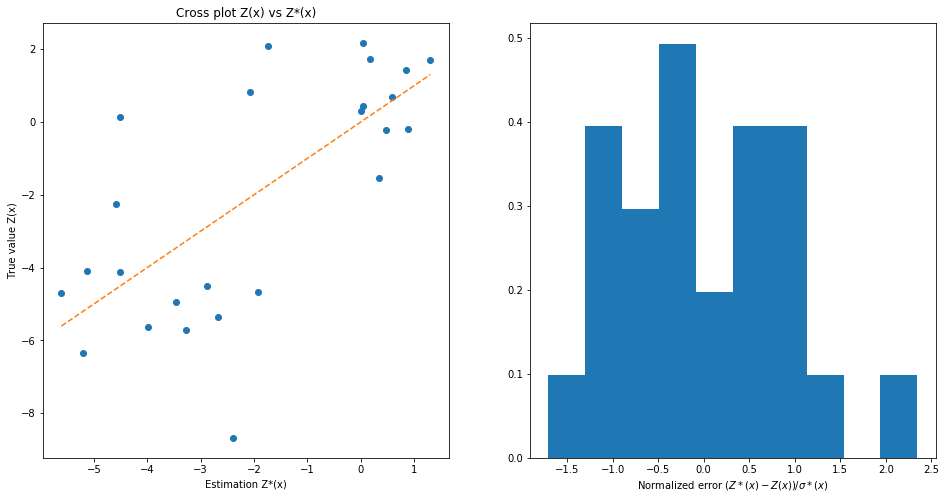

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [13]:
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))

### Data interpolation by ordinary kriging
The function `ordinary_kriging(x, v, xu, cov_model)` returns the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`.

For data in 1D:
- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the interpolation is done.

In return:
- `vu`: 1-dimensional array of length `m`, (ordinary) kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, (ordinary) kriging standard deviation at location `xu`.

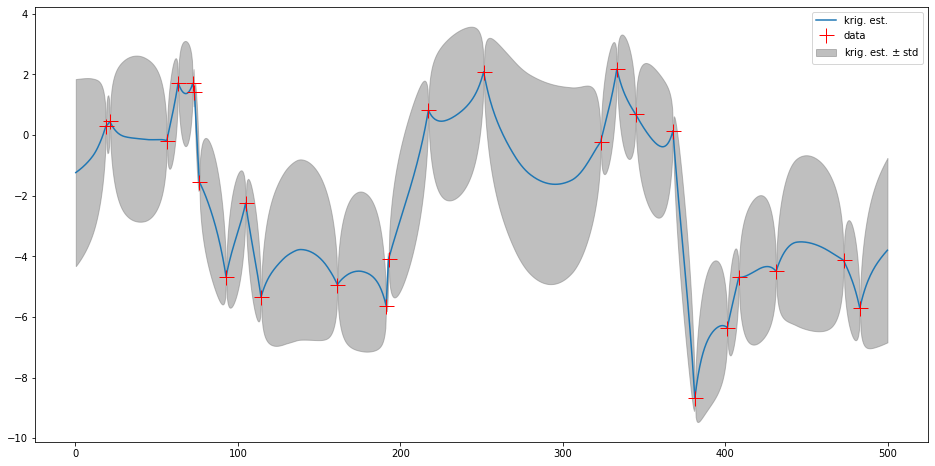

In [14]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*dx

# Ordinary kriging
vu, vu_std = gcm.ordinary_kriging(x, v, xu, cov_model_opt)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.show()

### Simple kriging (comparison)
Assuming the data (variable) stationary and specifying a constant mean (computed on the data set), the function `krige1D` (from `geone.grf` module, see jupyter notebook `ex_grf_1d`) can be used to compute simple krging estimates and standard deviation.

**Note:** a varying mean can also be specified.

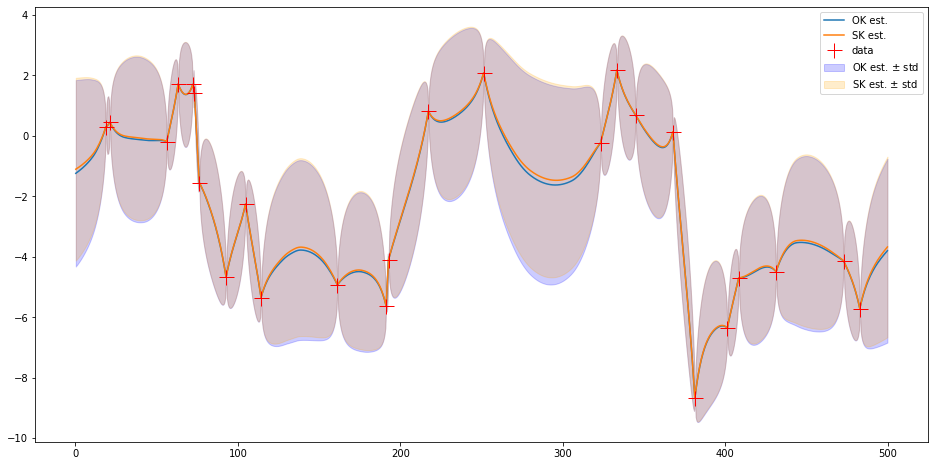

In [15]:
vu_sk, vu_sk_std = grf.krige1D(x, v, cov_model_opt, nx, dx, ox, mean=np.mean(v), printInfo=False)

# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, label='OK est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='blue', alpha=0.2, label=r'OK est. $\pm$ std')
plt.plot(xu, vu_sk, label='SK est.')
plt.fill_between(xu, vu_sk-vu_sk_std, vu_sk+vu_sk_std, color='orange', alpha=0.2, label=r'SK est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.show()

### Conditional simulation using the function `grf1D`
Specifying the same mean, the function `grf1D` (from `geone.grf` module, see jupyter notebook `ex_grf_1d`) can be used to generate conditional realizations (based on simple kriging).

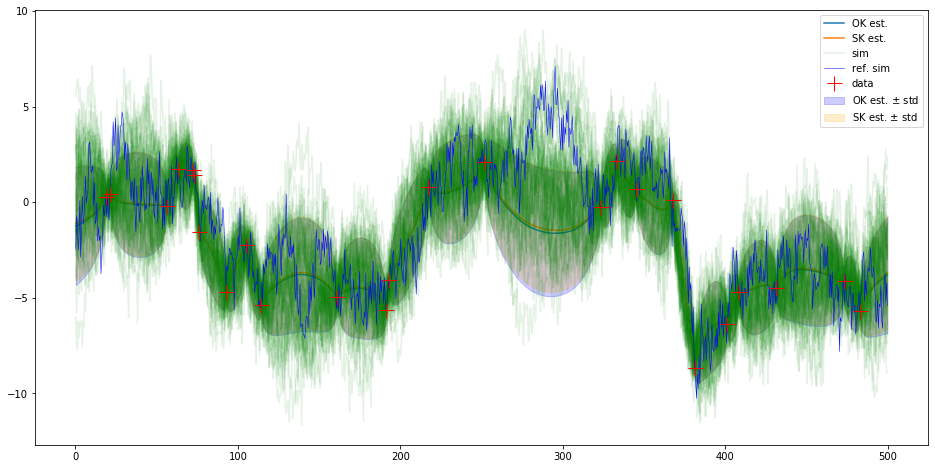

In [16]:
# Simulation
np.random.seed(293)
nreal = 50
sim = grf.grf1D(cov_model_ref, nx, dx, ox, x=x, v=v, nreal=nreal, printInfo=False) # 2d-array of shape nreal x nx

# Plot
plt.figure(figsize=(16,8))
plt.plot(xu, vu, label='OK est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='blue', alpha=0.2, label=r'OK est. $\pm$ std')
plt.plot(xu, vu_sk, label='SK est.')
plt.fill_between(xu, vu_sk-vu_sk_std, vu_sk+vu_sk_std, color='orange', alpha=0.2, label=r'SK est. $\pm$ std')
for i in range(nreal):
    if i == 0:
        label = 'sim'
    else:
        label = None
    plt.plot(xu, sim[i], color='green', alpha=.1, label=label)
plt.plot(xu, ref[0], color='blue', lw=.5, label='ref. sim')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.legend()
plt.show()